In [338]:
%reload_ext autoreload
%autoreload 2

In [339]:
import numpy as np
from scipy.stats import kde

import torch
import torch.optim as optim
import torch.distributions as tdist
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

from core import NormalizingFlow, DiagonalGaussian, FullRankGaussian

In [340]:
flow = NormalizingFlow(D=2)
torch.manual_seed(42)
_, log_prob_1 = flow.sample(n=100, efficient=False)
torch.manual_seed(42)
_, log_prob_2 = flow.sample(n=100, efficient=False)
print(torch.eq(log_prob_1, log_prob_2))

TypeError: __init__() missing 1 required positional argument: 'K'

## Potential function

### My custom potential function

In [341]:
def U_with_argument(z, angle, distance):
    rotational_matrix = torch.Tensor([
        [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle))],
        [torch.sin(torch.tensor(angle)), torch.cos(torch.tensor(angle))]
    ])
    z = (rotational_matrix @ z.T).T
    term1 = 0.5 * ((torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2) - distance) / 0.4) ** 2
    term2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + distance) / 0.6) ** 2) + 
        1e-5
    )
    return (term1 - term2)

In [342]:
def U_eight(z, divider=1):
    return U_with_argument(z, torch.pi/4, 3) + \
           U_with_argument(z, torch.pi / 2 + torch.pi/4, 3) + \
           U_with_argument(z, 0, 3) + \
           U_with_argument(z, torch.pi / 2, 3)

### Other potential functions from paper

In [343]:
def w1(z): return torch.sin(2 * torch.pi * z[:, 0] / 4)                 
def w2(z): return 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.5) ** 2)
def σ(x): return 1 / (1 + torch.exp(-x))
def w3(z): return 3 * σ((z[:, 0] - 1) / 0.3)

In [344]:
def taper(z):
    return torch.sigmoid(
        ( 5 - torch.linalg.vector_norm(z, dim=1, ord=np.inf) ) * 10
    )

In [345]:
def add_taper(potential):
    def new_potential(z):
        # so density is exp(-potential(z) + log(taper(z))) = exp(-potential(z)) * taper(z)
        return potential(z) - torch.log(taper(z))
    return new_potential

In [346]:
def U1(z):
    part_1 = (1/2) * ((torch.sqrt(z[:,0] ** 2 + z[:,1]**2) - 2) / 0.4) ** 2
    part_2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - 2) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + 2) / 0.6) ** 2)
    )
    return (part_1 - part_2)

In [347]:
@add_taper
def U2(z):
    return ((1/2) * ((z[:,1] - w1(z)) / 0.4) ** 2)

In [348]:
@add_taper
def U3(z):
    return - torch.log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    )

In [349]:
@add_taper
def U4(z):
    return - torch.log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.34) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    )

In [350]:
class GMM(torch.nn.Module):
    
    def __init__(self, D, K):
        super().__init__()
        self.K = K
       
        self.pre_π = torch.zeros(K, )
        self.μs = torch.nn.Parameter(torch.randn(K, D) * 0.1)
        self.pre_σs = torch.nn.Parameter(torch.randn(K, D) * 0.1)
        
        self.comp = tdist.Independent(tdist.Normal(self.μs, torch.exp(self.pre_σs)), 1)
        self.cat = tdist.Categorical(logits=self.pre_π)
    
    def sample(self, n):
        
        # sampling
        
        #mixer = F.gumbel_softmax(self.pre_π.repeat(n, 1).detach(), tau=self.tau, hard=True)  # (n, k)
        indices = self.cat.sample((n, ))  # (n,)
        samples_from_each_gaussian = self.comp.rsample(sample_shape=(n, ))  # (n, k, d)
        samples = samples_from_each_gaussian.gather(1, indices.view(-1, 1, 1).repeat(1, 1, 2)).squeeze()
        
        # log prob computation
        
        log_π = F.log_softmax(self.pre_π, dim=0)  # (k, )

        log_prob_under_each_gaussian = self.comp.log_prob(samples_from_each_gaussian)  # (n, k)
        temp = log_π.view(1, -1) + log_prob_under_each_gaussian  # (n, k)
        denom = torch.logsumexp(temp, dim=1)  # (n, )
        log_resps = temp - denom.view(-1, 1)  # (n, k)
        
        #log_prob_per_sample = torch.logsumexp(log_π.view(1, -1) + log_prob_under_each_gaussian, dim=1)
        log_prob_per_sample = torch.sum(
            torch.exp(log_resps) * (log_π.view(1, -1) + log_prob_under_each_gaussian),
            dim=1
        )
        
        return samples, log_prob_per_sample

In [351]:
class GMM(torch.nn.Module):
    
    def __init__(self, D, K):
        super().__init__()
        self.K = K
       
        self.pre_π = torch.zeros(K, )
        self.μs = torch.nn.Parameter(torch.zeros(K, D))
        self.pre_σs = torch.nn.Parameter(torch.ones(K, D))
        
        self.cat = tdist.Categorical(logits=self.pre_π)
    
    def sample(self, n):
        
        self.comp = tdist.Independent(tdist.Normal(self.μs, torch.exp(self.pre_σs)), 1)
        
        # sampling
        
        #mixer = F.gumbel_softmax(self.pre_π.repeat(n, 1).detach(), tau=self.tau, hard=True)  # (n, k)
        indices = self.cat.sample((n, ))  # (n,)
        samples_from_each_gaussian = self.comp.rsample(sample_shape=(n, ))  # (n, k, d)
        samples = samples_from_each_gaussian.gather(1, indices.view(-1, 1, 1).repeat(1, 1, 2)).squeeze()
        
        # log prob computation
        
        log_π = F.log_softmax(self.pre_π, dim=0)  # (k, )
        # log_π = log_π.view(1, -1).repeat(n, 1)
        # log_π = log_π.gather(1, indices.view(-1, 1))

        log_prob_under_each_gaussian = self.comp.log_prob(samples.view(n, 1, -1))  # (n, k)        
        
        temp = log_π.view(1, -1) + log_prob_under_each_gaussian  # (n, k)
        denom = torch.logsumexp(temp, dim=1)  # (n, )
        log_resps = temp - denom.view(-1, 1)  # (n, k)
        
        # log_prob_per_sample = torch.logsumexp(log_π + log_prob_under_each_gaussian, dim=1)
        log_prob_per_sample = torch.sum(
            torch.exp(log_resps) * (log_π.view(1, self.K) + log_prob_under_each_gaussian),
            dim=1
        )
        
        return samples, log_prob_per_sample

In [352]:
class GMM2(torch.nn.Module):
    
    def __init__(self, D, K):
        super().__init__()
        self.K = K
        self.D = D
        self.pre_π = torch.zeros(K, )
        self.μs = torch.nn.Parameter(torch.zeros(K, D))
        self.pre_σs = torch.nn.Parameter(torch.ones(K, D) * -1)  # small sd, otherwise might start in region with too low U, leading to nan
        
    def sample(self, n):
        self.comp = tdist.Independent(tdist.Normal(self.μs, torch.exp(self.pre_σs)), 1)
        self.cat = tdist.Categorical(logits=self.pre_π)
        indices = self.cat.sample((n, ))  # (n,)
        samples_from_each_gaussian = self.comp.rsample(sample_shape=(n, ))  # (n, k, d)
        samples = samples_from_each_gaussian.gather(1, indices.view(-1, 1, 1).repeat(1, 1, self.D)).squeeze()
        
        return samples, self.log_prob(samples)
        
    def log_prob(self, samples):
        n = samples.shape[0]
        log_π = F.log_softmax(self.pre_π, dim=0).view(1, -1)  # (1, k)
        log_prob_under_each_gaussian = self.comp.log_prob(samples.view(n, 1, self.D))  # (n, k)    
        log_prob_per_sample = torch.logsumexp(log_π + log_prob_under_each_gaussian, dim=1)
        return log_prob_per_sample

In [353]:
K = 100
D = 2
N = 20
dist = tdist.MultivariateNormal(
        torch.randn(K, D), 
        torch.eye(D).view(1, D, D).repeat(K, 1, 1)
    )
samples = dist.sample(sample_shape=(N, ))
print(samples.shape)
dist.log_prob(samples.view(N, K, D)).shape

torch.Size([20, 100, 2])


torch.Size([20, 100])

In [354]:
class GMM3(torch.nn.Module):
    
    def __init__(self, D, K):
        super().__init__()
        self.K = K
        self.D = D
        self.pre_π = torch.zeros(K, )
        #self.μs = torch.nn.Parameter((torch.rand(K, D) - 0.5) * 12)
        self.μs = torch.nn.Parameter(torch.zeros(K, D))
        self.pre_Σs = torch.nn.Parameter(
            torch.linalg.cholesky(torch.eye(D).view(1, D, D).repeat(K, 1, 1), upper=True)
        )
    
    def cov(self):
        temp = torch.triu(self.pre_Σs)
        return torch.bmm(temp.transpose(1, 2), temp)
    
    @property
    def comp(self):
        return tdist.MultivariateNormal(self.μs, self.cov())
    
    @property
    def cat(self):
        return tdist.Categorical(logits=self.pre_π)
        
    def sample(self, n):
        #mixer = F.gumbel_softmax(self.pre_π.repeat(n, 1), tau=0.1, hard=True, dim=-1)  # (n, k)
        #samples_from_each_gaussian = self.comp.rsample(sample_shape=(n, ))  # (n, k, d)
        #samples = torch.sum(mixer.view(n, -1, 1) * samples_from_each_gaussian, dim=1)
        indices = self.cat.sample((n, ))  # (n,)
        samples_from_each_gaussian = self.comp.rsample(sample_shape=(n, ))  # (n, k, d)
        samples = samples_from_each_gaussian.gather(1, indices.view(-1, 1, 1).repeat(1, 1, self.D)).squeeze()
        return samples, self.log_prob(samples)
        
    def log_prob(self, samples):
        n = samples.shape[0]
        log_π = F.log_softmax(self.pre_π, dim=0).view(1, -1)  # (1, k)
        log_prob_under_each_gaussian = self.comp.log_prob(samples.view(n, 1, self.D))  # (n, k)
        log_prob_per_sample = torch.logsumexp(log_π + log_prob_under_each_gaussian, dim=1)
        return log_prob_per_sample

In [355]:
# class GMM3(torch.nn.Module):
    
#     def __init__(self, D, K):
#         super().__init__()
#         self.K = K
       
#         self.pre_π = torch.nn.Parameter(torch.zeros(K, ))
#         self.μs = torch.nn.Parameter(torch.zeros(K, D))
#         self.pre_σs = torch.nn.Parameter(torch.ones(K, D))
        
#     def sample(self, n):
        
#         # distributions
        
#         self.comp = tdist.Independent(tdist.Normal(self.μs, torch.exp(self.pre_σs)), 1)
        
#         # sampling
        
#         mixer = F.gumbel_softmax(self.pre_π.repeat(n, 1), tau=1, hard=True, dim=-1)  # (n, k)
#         samples_from_each_gaussian = self.comp.rsample(sample_shape=(n, ))  # (n, k, d)
#         samples = torch.sum(mixer.view(n, -1, 1) * samples_from_each_gaussian, dim=1)
        
#         # log prob computation
        
#         return samples, self.log_prob(samples)
        
#     def log_prob(self, samples):
        
#         log_π = F.log_softmax(self.pre_π, dim=0).view(1, -1)  # (1, k)
#         log_prob_under_each_gaussian = self.comp.log_prob(samples.view(samples.shape[0], 1, -1))  # (n, k)    
#         log_prob_per_sample = torch.logsumexp(log_π + log_prob_under_each_gaussian, dim=1)
        
#         return log_prob_per_sample

## Choosing a potential function

In [357]:
potential = "U1"

if potential == "U1":
    U = U1
elif potential == "U2":
    U = U2
elif potential == "U3":
    U = U3
elif potential == "U4":
    U = U4
elif potential == "U8":
    U = U_eight

## Graphing potential function

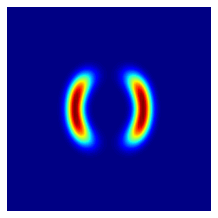

In [358]:
fig = plt.figure(figsize=(3.75, 3.75))

xs = torch.linspace(-6, 6, 100)
xxs, yys = torch.meshgrid(xs, xs)
xxs2, yys2 = xxs.reshape(-1, 1), yys.reshape(-1, 1)
unnorm_p = torch.exp(- U(torch.hstack([xxs2, yys2]))) #* decay(torch.hstack([xxs2, yys2]))

plt.contourf(xxs.numpy(), yys.numpy(), unnorm_p.reshape(100, 100).numpy(), levels=100, cmap="jet")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"imgs/{potential}_true_density.png", dpi=300, bbox_inches='tight')

In [359]:
torch.linalg.vector_norm(torch.randn(1, 2))

tensor(1.9105)

## Training

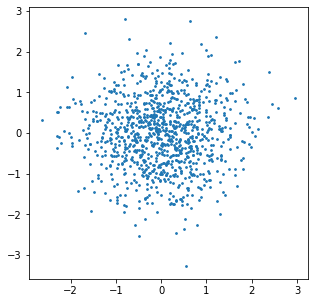

In [360]:
flow = NormalizingFlow(D=2, K=100)

with torch.no_grad():
    samples_untrained = flow.sample(n=1000, efficient=True)[0]
    
plt.figure(figsize=(5, 5))
plt.scatter(samples_untrained[:, 0], samples_untrained[:, 1], s=3)
#plt.xlim(-6, 6)
#plt.ylim(-6, 6)
plt.show()

In [361]:
flow = NormalizingFlow(D=2, K=100)
opt = optim.Adam(flow.parameters(), lr=2e-3)

start = time.perf_counter()

samples_kls = []

for i in range(1, 10001):
    
    samples_from_q_K, log_probs = flow.sample(n=1000, efficient=True)
    sample_kl = (log_probs + U(samples_from_q_K)).mean()  # monte-carlo estimate of the kl-divergence
    samples_kls.append(float(sample_kl))
    
    opt.zero_grad()
    sample_kl.backward()
    opt.step()

    if i % 100 == 0:
        
        print(i, float(sample_kl))
            
end = time.perf_counter()
end - start

100 -1.2650232315063477
200 -1.78687584400177
300 -1.8252614736557007


KeyboardInterrupt: 

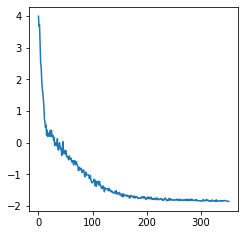

In [362]:
fig = plt.figure(figsize=(3.75, 3.75))
plt.plot(samples_kls)
plt.savefig(f"imgs/{potential}_kl_over_time.png", dpi=300, bbox_inches='tight')

## Graphing

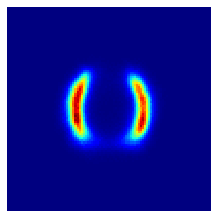

In [363]:
fig = plt.figure(figsize=(3.75, 3.75))

samples_qK, _ = flow.sample(n=int(1e6))
samples_qK = samples_qK.detach().numpy()

#samples_qK = samples_qK[np.bitwise_and(samples_qK[:,0] >= -4 , samples_qK[:,0] <= 4)]

# plt.hexbin(samples_qK[:,0], samples_qK[:,1], gridsize=50, cmap="turbo", extent=[-4, 4, -4, 4])
plt.hist2d(samples_qK[:,0], samples_qK[:,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])
    
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"imgs/{potential}_learned_density.png", dpi=300, bbox_inches='tight')

### n = 10000

In [336]:
# copied from stackoverflow
phi = np.linspace(0, 2*np.pi, n)
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = (np.stack((np.cos(phi          ), # Three sinusoids,
                       np.cos(phi+2*np.pi/3), # 120° phase shifted,
                       np.cos(phi-2*np.pi/3)
                      )).T # Shape = (60,3)
             + 1)*0.5   

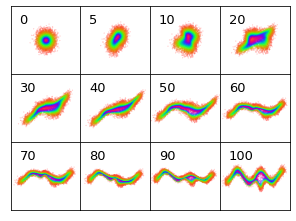

In [337]:
samples_from_each_layer = flow.sample_from_each_layer(n=n)
samples_from_each_layer = [samples.detach().numpy() for samples in samples_from_each_layer]

indices = np.argsort(
    (samples_from_each_layer[0][:,0] - float(flow.μ[0])) ** 2 + 
    (samples_from_each_layer[0][:,1] - float(flow.μ[1])) ** 2
)

fig = plt.figure(figsize=(5, 5 / 4 * 3), )
for i, j in enumerate([0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    fig.add_subplot(3, 4, i+1)
    plt.scatter(samples_from_each_layer[j][:,0][indices], 
                samples_from_each_layer[j][:,1][indices], 
                color=rgb_cycle,
                s=0.01, alpha=1)
    plt.text(-4.5, 3, f"{j}", size=13)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.xticks([])
    plt.yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig(f"imgs/{potential}_samples_from_each_layer.png", dpi=300, bbox_inches='tight')

## Unused code

In [ ]:
# connecting lines between points in q0 and points in qk

# samples_q0, samples_qK, _ = flow.sample_and_return_log_prob(n=1000)
# samples_q0 = samples_q0.detach().numpy()
# samples_qK = samples_qK.detach().numpy()

# for i in range(len(samples_q0)):
#     plt.plot([samples_q0[i][0] + 5, samples_qK[i][0]], 
#              [samples_q0[i][1] + 5, samples_qK[i][1]], 
#              color="black", linewidth=0.2, alpha=0.1)

# plt.scatter(samples_q0[:,0] + 5, samples_q0[:,1] + 5, s=5, color="green", alpha=0.1)
# plt.scatter(samples_qK[:,0], samples_qK[:,1], s=5, color="red", alpha=0.1)
    
# #plt.xlim(-4, 4)
# #plt.ylim(-4, 4)
# plt.axis("off")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("flow.png", dpi=300)

In [ ]:
# density plot with Gaussian KDE

# _, samples_qK, _ = flow.sample_and_return_log_prob(n=100000)
# samples_qK = samples_qK.detach().numpy()

# x, y = samples_qK[:,0], samples_qK[:,1]
# nbins = 50
# xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), nbins), np.linspace(y.min(), y.max(), nbins))

# k = kde.gaussian_kde(samples_qK.T, bw_method=0.02)
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# plt.contourf(xi, yi, zi.reshape(xi.shape), levels=20, cmap="turbo")

# plt.xlim(-4, 4)
# plt.ylim(-4, 4)
# plt.axis("off")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("u4_density_estimated.png", dpi=1000)